In [21]:
import json
import numpy as np
import os
import cv2
import scipy.io as sio
import copy
import random
from glob import glob
from tqdm import tqdm
from pathlib import Path
import sys
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

In [140]:
def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]
def split_batchs(elems, n):
    for idx in range(0, len(elems), n):
        yield elems[idx:idx + n]

root_path = "/aidata/anders/objects/3D-head/gpu_usage"
paths = glob(os.path.join(root_path, '*.out'))
total = {}
for path in paths:
    method = path.split('/')[-1]
    gpu_logs = load_text(path)
    A = list(range(0, len(gpu_logs[1:]), 46))
    batch_size = 46
    # #Date       Time        gpu    fb  bar1    sm   mem   enc   dec
    batch_objects = list(split_batchs(gpu_logs[1:], batch_size))
    records = {'time':[], 'usage' :[]}
    for i, batch_object in enumerate(batch_objects):
        for j, element in enumerate(batch_object):
            if j > 1:
                element = element.split(' ')
                tmp = []
                for e in element:
                    if e == ' ' or e == '':
                        continue
                    tmp.append(e)
                if int(tmp[3]) < 300:
                    continue
                if int(tmp[5]) < 50:
                    continue
                records['time'].append(
                    pd.to_datetime(tmp[1], format='%H:%M:%S')) 
                records['usage'].append(float(tmp[5]))
    df = pd.DataFrame(records)
    df = df.set_index('time') 
    # td = df.set_index(pd.DatetimeIndex(pd.to_datetime(df['time'])))
    sample_5mins = df.resample('5T', label='right', closed='right').mean()
    total[method] = sample_5mins

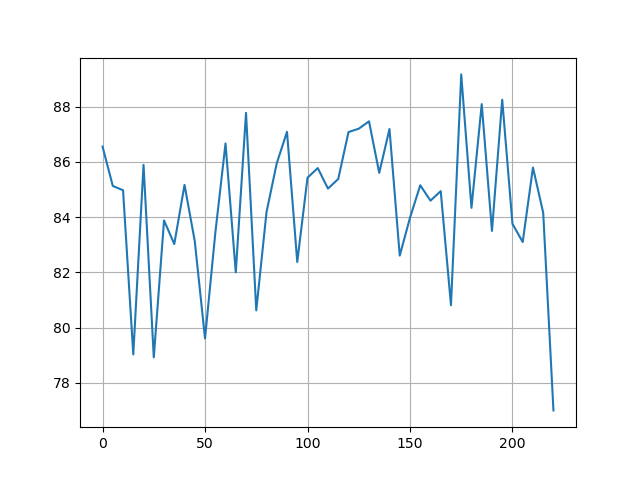

In [141]:
keys = total.keys()
step = 5 
fig = plt.figure()
for key in keys:
    method = total[key]
    time_stamp = pd.to_datetime(method.index, format='%H:%M:%S').time
    m = len(time_stamp)
    time_steps = [i*5 for i in range(m)]
    values = method['usage'].to_numpy()
    plt.plot(time_steps, values)
plt.grid()


